# 7 Fine-tuning to follow instructions

In [36]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.3.4
matplotlib version: 3.10.7
tiktoken version: 0.9.0
torch version: 2.9.0
tqdm version: 4.67.1
tensorflow version: 2.20.0


## 7.2 Preparing a dataset for supervised instruction finetuning

In [ ]:
import json

file_path = "instruction-data.json"

with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

print("Number of entries:", len(data))

Number of entries: 1100


In [38]:
data[50]

{'instruction': 'Identify the correct spelling of the following word.',
 'input': 'Ocassion',
 'output': "The correct spelling is 'Occasion.'"}

In [39]:
data[999]

{'instruction': "What is an antonym of 'complicated'?",
 'input': '',
 'output': "An antonym of 'complicated' is 'simple'."}

In [40]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [41]:
format_input(data[50])

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the correct spelling of the following word.\n\n### Input:\nOcassion'

In [42]:
print(format_input(data[50]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion


In [43]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [44]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [45]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 Organizing data into training batches

We pad on batch basis (to the longest element in the batch)

In [46]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        super().__init__()
        self.data = data

        # Pre-tokenized texts
        self.encoded_text = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_text.append(tokenizer.encode(full_text))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.encoded_text[index]

In [47]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

We define a collate function which determines a set of operation we want the dataloader to perform on each batch when its iterating over batches

In [48]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):

    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # add an <|endoftext|> token
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * ((batch_max_length) - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [49]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [50]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):

    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # add an <|endoftext|> token
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * ((batch_max_length) - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [51]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs_tensor, targets_tensor = custom_collate_draft_2(batch)
print(inputs_tensor)
print(targets_tensor)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [52]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):

    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # add an <|endoftext|> token
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * ((batch_max_length) - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        # if len(targets) > (len(item) + 1):
        #     targets[:-(len(targets) - (len(item) + 1))] = 

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]


        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [53]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs_tensor, targets_tensor = custom_collate(batch)
print(inputs_tensor)
print(targets_tensor)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [54]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [55]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [56]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


## 7.4 Creating data loaders for an instruction dataset

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [58]:
from functools import partial
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [59]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size, collate_fn=customized_collate_fn, shuffle=True, drop_last=True, num_workers=num_workers)

In [60]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [61]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 56]) torch.Size([8, 56])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 82]) torch.

In [62]:
inputs[0]

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198,  8645,   378,   257,  6827,  1262,   262,
         1573,   705, 15103,  6985,  4458,   198,   198, 21017, 18261,    25,
          198,  3347,   318,   845, 47628,   290,  1464, 13831,  3241,   284,
         3307,    13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')

In [63]:
targets[0]

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198,  8645,   378,   257,  6827,  1262,   262,  1573,
          705, 15103,  6985,  4458,   198,   198, 21017, 18261,    25,   198,
         3347,   318,   845, 47628,   290,  1464, 13831,  3241,   284,  3307,
           13, 50256,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')

## 7.5 Loading a pretrained LLM

In [64]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2025-11-30 23:44:39.181065: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 23:44:39.922408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 23:45:04.703824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 19.4kiB/s]
encoder.json: 100%|████████

In [65]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [ ]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)


token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [67]:
generated_text

"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Response:\n\nThe chef cooks the meal every day.\n\n### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the"

In [68]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## 7.6 Fintuning the LLM on instruction data

In [69]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

In [70]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8259093284606935
Validation loss: 3.7619336605072022


In [72]:
import time

start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=5, start_context=format_input(val_data[0]), tokenizer=tokenizer)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.304, Val loss 0.673
Ep 1 (Step 000005): Train loss 0.284, Val loss 0.695
Ep 1 (Step 000010): Train loss 0.319, Val loss 0.704
Ep 1 (Step 000015): Train loss 0.305, Val loss 0.682
Ep 1 (Step 000020): Train loss 0.344, Val loss 0.700
Ep 1 (Step 000025): Train loss 0.315, Val loss 0.713
Ep 1 (Step 000030): Train loss 0.352, Val loss 0.717
Ep 1 (Step 000035): Train loss 0.277, Val loss 0.714
Ep 1 (Step 000040): Train loss 0.290, Val loss 0.706
Ep 1 (Step 000045): Train loss 0.332, Val loss 0.716
Ep 1 (Step 000050): Train loss 0.324, Val loss 0.711
Ep 1 (Step 000055): Train loss 0.276, Val loss 0.724
Ep 1 (Step 000060): Train loss 0.276, Val loss 0.718
Ep 1 (Step 000065): Train loss 0.275, Val loss 0.701
Ep 1 (Step 000070): Train loss 0.297, Val loss 0.690
Ep 1 (Step 000075): Train loss 0.261, Val loss 0.673
Ep 1 (Step 000080): Train loss 0.259, Val loss 0.678
Ep 1 (Step 000085): Train loss 0.273, Val loss 0.672
Ep 1 (Step 000090): Train loss 0.261, Val loss

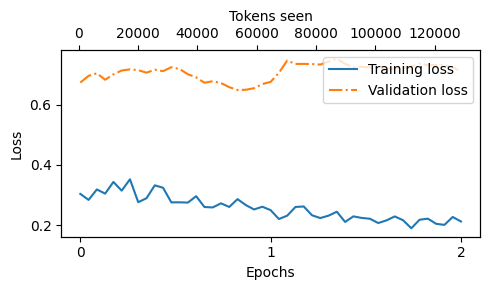

In [73]:
from previous_chapters import plot_losses
# Alternatively:
# from llms_from_scratch.ch05 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 7.7 Extracting and saving responses

In [74]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a cumulus or stratus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The aut

In [75]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [00:14<00:00,  7.46it/s]


In [76]:
test_data[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a cheetah.'}

In [77]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## 7.8 Evaluating the finetuned LLM